# Using the Gaussian Mixture Model (GMM) for the clustering of 2D blobs - A simple example

*Costas Andreopoulos \<c.andreopoulos@cern.ch\>*

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse

from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

**Generate and plot synthetic data**

In [2]:
n_samples = 300
n_features = 2
n_true_clusters = 5
random_state = 40

X, Y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_true_clusters, random_state=random_state)

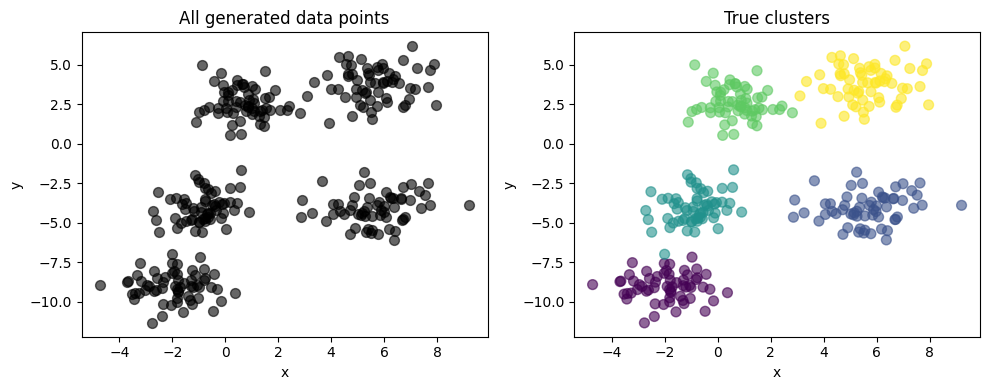

In [3]:
fig = plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(1,2,width_ratios=[1,1])
axL = fig.add_subplot(gs[0,0])
axL.scatter(X[:, 0], X[:, 1], color='black', s=50, alpha=0.6)
axL.set_title('All generated data points')
axL.set_xlabel("x")
axL.set_ylabel("y")
axR = fig.add_subplot(gs[0,1])
axR.scatter(X[:, 0], X[:, 1], c=Y, cmap='viridis', s=50, alpha=0.6)
axR.set_title('True clusters')
axR.set_xlabel("x")
axR.set_ylabel("y")
plt.tight_layout()
plt.show()

**Finding the optimal number of clusters**

Unlike the k-Means algorithm, where the optimal number of clusters is found using the **Elbow method** heuristic,
GMM, which doesn't use **inertia** (sum of squared distances), requires a probabilistic metric.
A good choice helps balance model complexity vs. goodness of fit, and it prevent overfitting by penalizing too many parameters.

Common choices are the **Bayesian Information Criterion (BIC)** and the **Akaike Information Criterion (AIC)**.

For a GMM with $k$ clusters built from $N$ points, using $p$ parameters and resulting in a likelihood value $\cal{L}$,

BIC = $-2log\cal{L} + p logN$
    
AIC = $-2log\cal{L} + 2p$

BIC is more conservative, often preferring fewer clusters.
AIC may select a slightly higher number of clusters, as it penalizes complexity less.

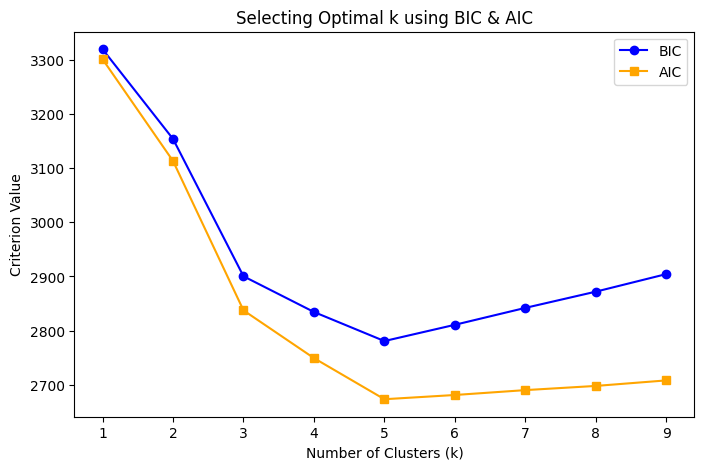

Optimal number of clusters (BIC): 5
Optimal number of clusters (AIC): 5


In [4]:
cluster_range = range(1, 2*n_true_clusters)
bics, aics = [], []

# Fit GMM for each cluster count and compute BIC & AIC
for k in cluster_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X)
    bics.append(gmm.bic(X))
    aics.append(gmm.aic(X))

# Find the optimal number of clusters (lowest BIC)
optimal_k_bic = cluster_range[np.argmin(bics)]
optimal_k_aic = cluster_range[np.argmin(aics)]

# Plot BIC and AIC values
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, bics, marker='o', label="BIC", color='blue')
plt.plot(cluster_range, aics, marker='s', label="AIC", color='orange')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Criterion Value")
plt.title("Selecting Optimal k using BIC & AIC")
plt.legend()
plt.xticks(cluster_range)
plt.show()

print(f"Optimal number of clusters (BIC): {optimal_k_bic}")
print(f"Optimal number of clusters (AIC): {optimal_k_aic}")

**Run the Gaussian Mixture Model for the optimal number of clusters**

In [5]:
# Looking at the above plot, select the point (number of clusters)  
n_clusters_optimal = 5

# Apply Gaussian Mixture clustering
# The initial parameters in the Expectation-Maximization algorithm affect convergence and can result in different solutions.
# Here, using kMeans clustering to initialize.
gmm = GaussianMixture(n_components=n_clusters_optimal, random_state=random_state, init_params='kmeans')
Y_gmm = gmm.fit_predict(X)

# Check if GMM converged
print(f"GMM converged? {gmm.converged_}")

GMM converged? True


**Visualize the GMM clusters**

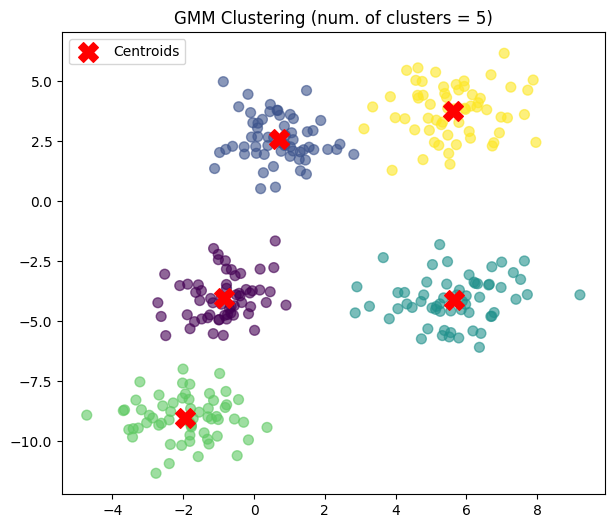

In [6]:
# Visualize the GMM clusters and centroids
plt.figure(figsize=(7,6))
plt.scatter(X[:, 0], X[:, 1], c=Y_gmm, cmap='viridis', s=50, alpha=0.6)
plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], s=200, c='red', marker='X', label='Centroids')
plt.title(f"GMM Clustering (num. of clusters = {n_clusters_optimal})")
plt.legend()
plt.show()

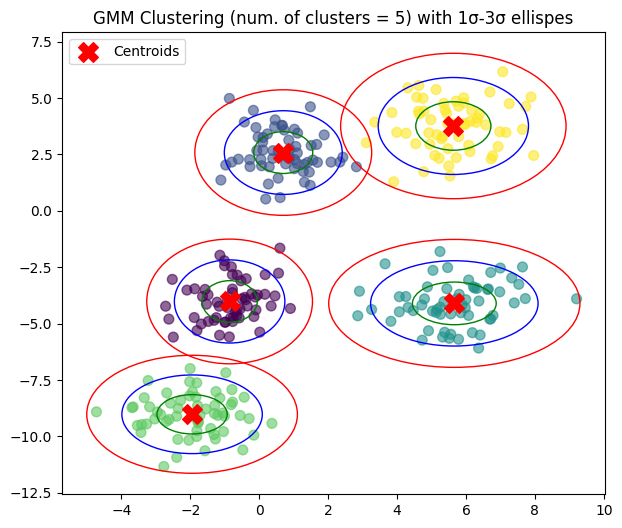

In [7]:
# Redo the above plot, but take the reported covariance for each cluster and 
# plot an ellipse around each centroid to indicate its estimated spread.

def plot_ellipse(mean, covariance, ax, n_std, **kwargs):
    """Plot an ellipse representing the Gaussian component spread."""
    # Get standard deviations 
    std_x, std_y = np.sqrt(np.diag(covariance))
    # Create an ellipse
    ellipse = Ellipse(xy=mean, width=2*n_std*std_x, height=2*n_std*std_y, **kwargs)
    ellipse.set_edgecolor(kwargs.get("edgecolor", "red"))
    ellipse.set_facecolor("none")  # No fill
    return ellipse

fig, ax = plt.subplots(figsize=(7,6))
ax.scatter(X[:, 0], X[:, 1], c=Y_gmm, cmap='viridis', s=50, alpha=0.6)
ax.scatter(gmm.means_[:, 0], gmm.means_[:, 1], s=200, c='red', marker='X', label='Centroids')
for mean, cov in zip(gmm.means_, gmm.covariances_):
    ellipse_1sig = plot_ellipse(mean, cov, ax, n_std=1, edgecolor="green")
    ax.add_patch(ellipse_1sig)
    ellipse_2sig = plot_ellipse(mean, cov, ax, n_std=2, edgecolor="blue")
    ax.add_patch(ellipse_2sig)
    ellipse_3sig = plot_ellipse(mean, cov, ax, n_std=3, edgecolor="red")
    ax.add_patch(ellipse_3sig)

ax.set_title(f"GMM Clustering (num. of clusters = {n_clusters_optimal}) with 1σ-3σ ellispes")
ax.legend()
plt.show()

The **silhouette score** for the data point $i$ is given by

$\displaystyle S{i} = \frac{b(i)-a(i)}{max\{b(i),a(i)\}}$

where $a(i)$ is the average distance between the point $i$ and all other points in its cluster, whereas $b(i)$ is the average distance between i and all points in the nearest cluster.

Average silhouette score for GMM clustering: 0.67


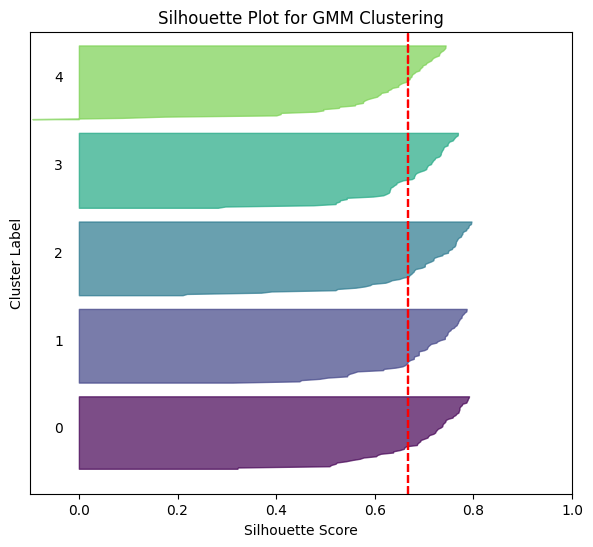

In [8]:
def plot_silhouette_score(X, Y_cluster, n_clusters, cluster_algo_label, ax):
    """
    Plot the silhouette score for every data point. Sort the points according to the score and group in assigned clusters.
    Compare with the average silhouette score.
    """
    # Compute the average silhouette score
    slsc_av = silhouette_score(X, Y_cluster)
    print(f"Average silhouette score for {cluster_algo_label} clustering: {slsc_av:.2f}")
    
    # Get the silhouette score for each point
    slsc = silhouette_samples(X, Y_cluster)

    y_lower =  0 
    y_upper = 10 
    for i in range(n_clusters):
        # Get the sillhouete scores for all points in current cluster and sort them
        slsc_cl = slsc[Y_cluster == i]
        slsc_cl.sort()    
        # Color a band between x = 0 and x = silhouette score, for each data point in the current cluster
        y_lower = y_upper + 10
        y_upper = y_lower + len(slsc_cl)    
        color = cm.viridis(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, slsc_cl, facecolor=color, edgecolor=color, alpha=0.7)    
        ax.text(-0.05, y_lower + 0.5 * len(slsc_cl), str(i))    

        # Add a line showing the average silhouette score 
        ax.axvline(slsc_av, color="red", linestyle="--")

        ax.set_xlabel("Silhouette Score")
        ax.set_ylabel("Cluster Label")
        ax.set_title(f"Silhouette Plot for {cluster_algo_label} Clustering")
        ax.set_xlim([-0.1, 1])
        ax.set_ylim([0, len(X) + (n_clusters + 2) * 10])
        ax.set_yticks([])

fig, ax = plt.subplots(figsize=(7,6))
plot_silhouette_score(X, Y_gmm, n_clusters_optimal, "GMM", ax)

**Study the probability of each sample belonging to each Gaussian cluster**

In [16]:
# plt.figure(figsize=(8, 5))
# data_point_range = np.array(range(n_samples))
# probs = np.exp(gmm.score_samples(X))

# for i in range(n_clusters_optimal):
#     plt.hist(probs[Y_gmm == i], alpha=0.6, bins=50)

# plt.yscale("log")
# plt.show()